In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)


In [ ]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    resaved_file_name = 'resaved_image.jpg'    
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    ela_image = ImageChops.difference(original_image,resaved_image)
    
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 255 / max_difference
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [ ]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0        

In [ ]:
X = []
Y = []

In [ ]:

path = '../Datasets/CASIA_FIDAC/Au/'      
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
        try:
            full_path = os.path.join(path, filename)
            X.append(prepare_image(full_path))        
            Y.append(1)     
        except:
            pass

print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/250 [00:00<?, ?it/s]

Total images: 244
Total labels: 244


In [ ]:

path = '../Datasets/CASIA_FIDAC/Tp/'      
i=0
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
            i+=1
            try:
                full_path = os.path.join(path, filename)
                X.append(prepare_image(full_path))        
                Y.append(0)    
            except:
                pass

   
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/250 [00:00<?, ?it/s]

Total images: 494
Total labels: 494


In [ ]:
from sklearn.utils import shuffle



In [ ]:
X = np.array(X)
Y = np.array(Y)
X,Y= shuffle(X,Y)

X = X.reshape(-1, 128, 128, 3)



np.save('proposed_fidac_500_x.npy', X, allow_pickle=True)
np.save('proposed_fidac_500_y.npy', Y, allow_pickle=True)


In [ ]:
X = np.load('../Numpy arrays/proposed_casia_fidac_500_x.npy', allow_pickle=True)
Y = np.load('../Numpy arrays/proposed_casia_fidac_500_y.npy', allow_pickle=True)

print(np.shape(X),np.shape(Y))

(494, 128, 128, 3) (494,)


In [ ]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 375 , Training labels: 375
Validation images: 94 , Validation labels: 94
Test images: 25 , Test labels: 25


In [ ]:
print(Y_test)

[1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1]


In [ ]:
train_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    #zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)
test_gen =  ImageDataGenerator()

train_gen.fit(X_train)
test_gen.fit(X_val)

augmented_data = []


In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(256, (3,3), activation = 'relu'))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding = "SAME"))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 26, 26, 128)       147584    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 128)     

In [ ]:
epochs = 50
batch_size = 19


In [ ]:
init_lr = 1e-4  
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [ ]:
hist = model.fit(train_gen.flow(X_train, Y_train, batch_size=19),
                 batch_size = batch_size,
                 epochs = epochs,
                 #steps_per_epoch = 14,
                 validation_data = train_gen.flow(X_train, Y_train, batch_size=19))
                 #callbacks = [early_stopping])

Epoch 1/50
20/20 [==============================] - 56s 3s/step - loss: 0.4346 - accuracy: 0.8107 - val_loss: 0.3967 - val_accuracy: 0.8240
Epoch 2/50
20/20 [==============================] - 54s 3s/step - loss: 0.4041 - accuracy: 0.8267 - val_loss: 0.3696 - val_accuracy: 0.8373
Epoch 3/50
20/20 [==============================] - 48s 2s/step - loss: 0.4514 - accuracy: 0.8160 - val_loss: 0.3835 - val_accuracy: 0.8373
Epoch 4/50
20/20 [==============================] - 48s 2s/step - loss: 0.4019 - accuracy: 0.8213 - val_loss: 0.3655 - val_accuracy: 0.8480
Epoch 5/50
20/20 [==============================] - 46s 2s/step - loss: 0.4055 - accuracy: 0.8267 - val_loss: 0.3852 - val_accuracy: 0.8267
Epoch 6/50
20/20 [==============================] - 47s 2s/step - loss: 0.4401 - accuracy: 0.8053 - val_loss: 0.3800 - val_accuracy: 0.8400
Epoch 7/50
20/20 [==============================] - 48s 2s/step - loss: 0.3927 - accuracy: 0.8187 - val_loss: 0.3721 - val_accuracy: 0.8400
Epoch 8/50
20/20 [==

In [ ]:
model.save('ela_casia.h5') 

history_dict = hist.history
json.dump(history_dict, open('model_history', 'w'))

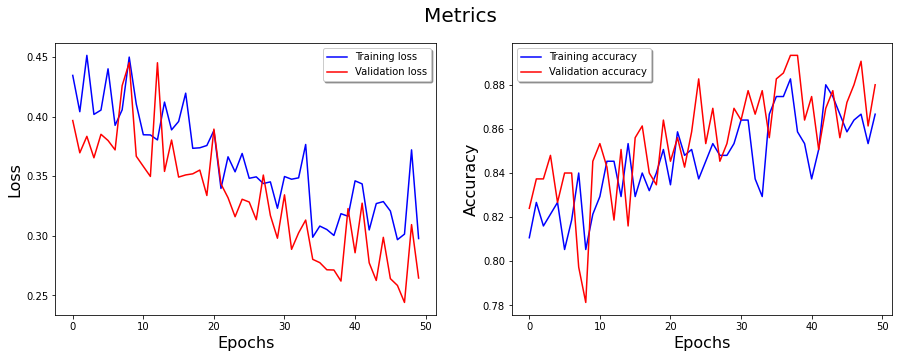

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss",axes =ax[0])
ax[0].set_xlabel('Epochs',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20);

In [ ]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

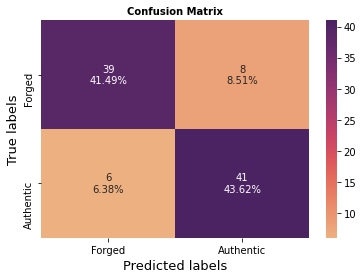

In [ ]:
Y_pred = model.predict(X_val)              
Y_pred_classes = np.round(Y_pred)           
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     
plot_confusion_matrix(confusion_mtx)                         


In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        47
           1       0.84      0.87      0.85        47

    accuracy                           0.85        94
   macro avg       0.85      0.85      0.85        94
weighted avg       0.85      0.85      0.85        94



In [ ]:
class_names = ['Forged', 'Authentic']

In [ ]:
correct_test = 0
total_test = 0  

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: 
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/25 [00:00<?, ?it/s]

Total test images: 25
Correctly predicted images: 20
Accuracy: 80.0 %


In [ ]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
fake_image = '../Datasets/TEST/Tp/'
correct = 0
total = 0
for file_name in os.listdir(fake_image):
    if file_name.endswith('jpg') or file_name.endswith('png'):
        test_image_path = os.path.join(fake_image, file_name)
        test_image = prepare_image(test_image_path)  
        test_image=test_image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(test_image)
        y_pred_class = round(y_pred[0][0])
        total += 1
        if y_pred_class == 0:
            correct += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Class: Forged Confidence: 10.14
Class: Forged Confidence: 33.44
Class: Forged Confidence: 4.80
Class: Forged Confidence: 23.49
Class: Forged Confidence: 24.12
Class: Forged Confidence: 1.37
Class: Forged Confidence: 19.17
Class: Forged Confidence: 7.22
Class: Forged Confidence: 36.74
Class: Forged Confidence: 3.83
Class: Forged Confidence: 48.17
Class: Forged Confidence: 25.50
Class: Forged Confidence: 18.09
Class: Forged Confidence: 18.42
Class: Forged Confidence: 10.34
Class: Forged Confidence: 4.17
Class: Forged Confidence: 4.88
Class: Forged Confidence: 17.05
Class: Forged Confidence: 5.56
Class: Forged Confidence: 0.17
Class: Forged Confidence: 4.59
Class: Forged Confidence: 1.77
Class: Forged Confidence: 3.42
Class: Forged Confidence: 27.62
Class: Forged Confidence: 28.49
Class: Forged Confidence: 32.53
Class: Forged Confidence: 4.24
Class: Forged Confidence: 10.34
Class: Forged Confidence: 17.51
Class: Forged Confidence: 42.06
Class: Forged Confidence: 18.73
Class: Forged Confid

In [ ]:
real_image = '../Datasets/Test/Au/'
correct_r = 0
total_r = 0
for file_name in os.listdir(real_image):
    if file_name.endswith('jpg') or file_name.endswith('png'):
        test_image_path = os.path.join(real_image, file_name)
        test_image = prepare_image(test_image_path)  
        test_image=test_image.reshape(-1, 128, 128, 3) 
        y_pred = model.predict(test_image)
        y_pred_class = round(y_pred[0][0])
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')

Class: Authentic Confidence: 99.84
Class: Authentic Confidence: 99.84
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.93
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.99
Class: Authentic Confidence: 99.69
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 96.89
Class: Authentic Confidence: 99.73
Class: Authentic Confidence: 99.57
Class: Authentic Confidence: 99.86
Class: Authentic Confidence: 99.26
Class: Authentic Confidence: 88.27
Class: Authentic Confidence: 67.10
Class: Authentic Confidence: 70.39
Class: Authentic Confidence: 99.86
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 82.61
Class: Authentic Confidence: 96.75
Class: Authentic Confidence: 97.38
Class: Authentic Confidence: 95.78
Class: Authentic Confidence: 98.61
Class: Authentic Confidence: 80.73
Class: Authe

In [ ]:
correct += correct_r
total += total_r
#print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 99, Correct: 84, Acc: 84.84848484848484


In [ ]:
# test_image_path = '../casia2/test/1.JPG'    # test image path
# test_image = prepare_image(test_image_path)
# test_image = test_image.reshape(-1, 128, 128, 3)

# y_pred = model.predict(test_image)
# y_pred_class = int(round(y_pred[0][0]))

# fig, ax = plt.subplots(1,2,figsize=(15,5)) 

# original_image = plt.imread(test_image_path) 
# ax[0].axis('off')
# ax[0].imshow(original_image)
# ax[0].set_title('Original Image')

# ax[1].axis('off')
# ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
# ax[1].set_title('ELA Image')

# print(f'Prediction: {class_names[y_pred_class]}')
# if y_pred<=0.5:
#     print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
# else:
#     print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
# print('--------------------------------------------------------------------------------------------------------------')

In [ ]:
# test_folder_path = 'Datasets/FIDAC/Au/'        #dataset path
# authentic,forged,total = 0,0,0

# for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
#     #print(filename)
#     if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg') or filename.endswith('JPG'):
#         test_image_path = os.path.join(test_folder_path, filename)
#         test_image = prepare_image(test_image_path)  
#         test_image=test_image.reshape(-1, 128, 128, 3)
#         #y_pred = model.predict(image)
#         #y_pred_class = np.round(y_pred)
        
#         y_pred = model.predict(test_image)
#         y_pred_class = round(y_pred[0][0])

#         total += 1
#         #print('---',y_pred_class)
#         if y_pred_class == 0:
#             forged += 1
#         else:
#             authentic +=1

# print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Processing Images :   0%|          | 0/14 [00:00<?, ?it/s]

Total images: 14
Authentic Images: 14
Forged Images: 0
